# Data Preparation - Imputing Missing Features
---
Instead of dropping the features where banned players are missing a lot of values, I want to attempt to impute them.

In [1]:
from Utils import setup_database_connection, true, false
from Utils import load_all_players
from Utils import COLOUR_BANNED, COLOUR_NON_BANNED, COLOUR_BLUE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

engine = setup_database_connection()
player_data = load_all_players(engine)
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

Connecting to database...
Connection successful!
Loaded 259587 players


This is a repeat of the mean distributions for each feature from before, this is what we will be comparing against when we impute missing values. We don't want to use the below features.

In [2]:
features_to_exclude = ['he_friends_damage_avg', 'rating_opening', 'rating_ct_leetify', 'rating_t_leetify', 't_opening_aggression_success_rate', 'rating_clutch', 'steam_id', 'created_at', 'updated_at', 'rank_premier', 'rank_faceit_elo', 'total_matches']

In [10]:
numeric_cols = player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in features_to_exclude]

banned_means = banned_player_data[numeric_cols].mean()
non_banned_means = non_banned_player_data[numeric_cols].mean()

difference = banned_means - non_banned_means

comparison_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Non-Banned Mean': non_banned_means.values,
    'Banned Mean': banned_means.values,
})


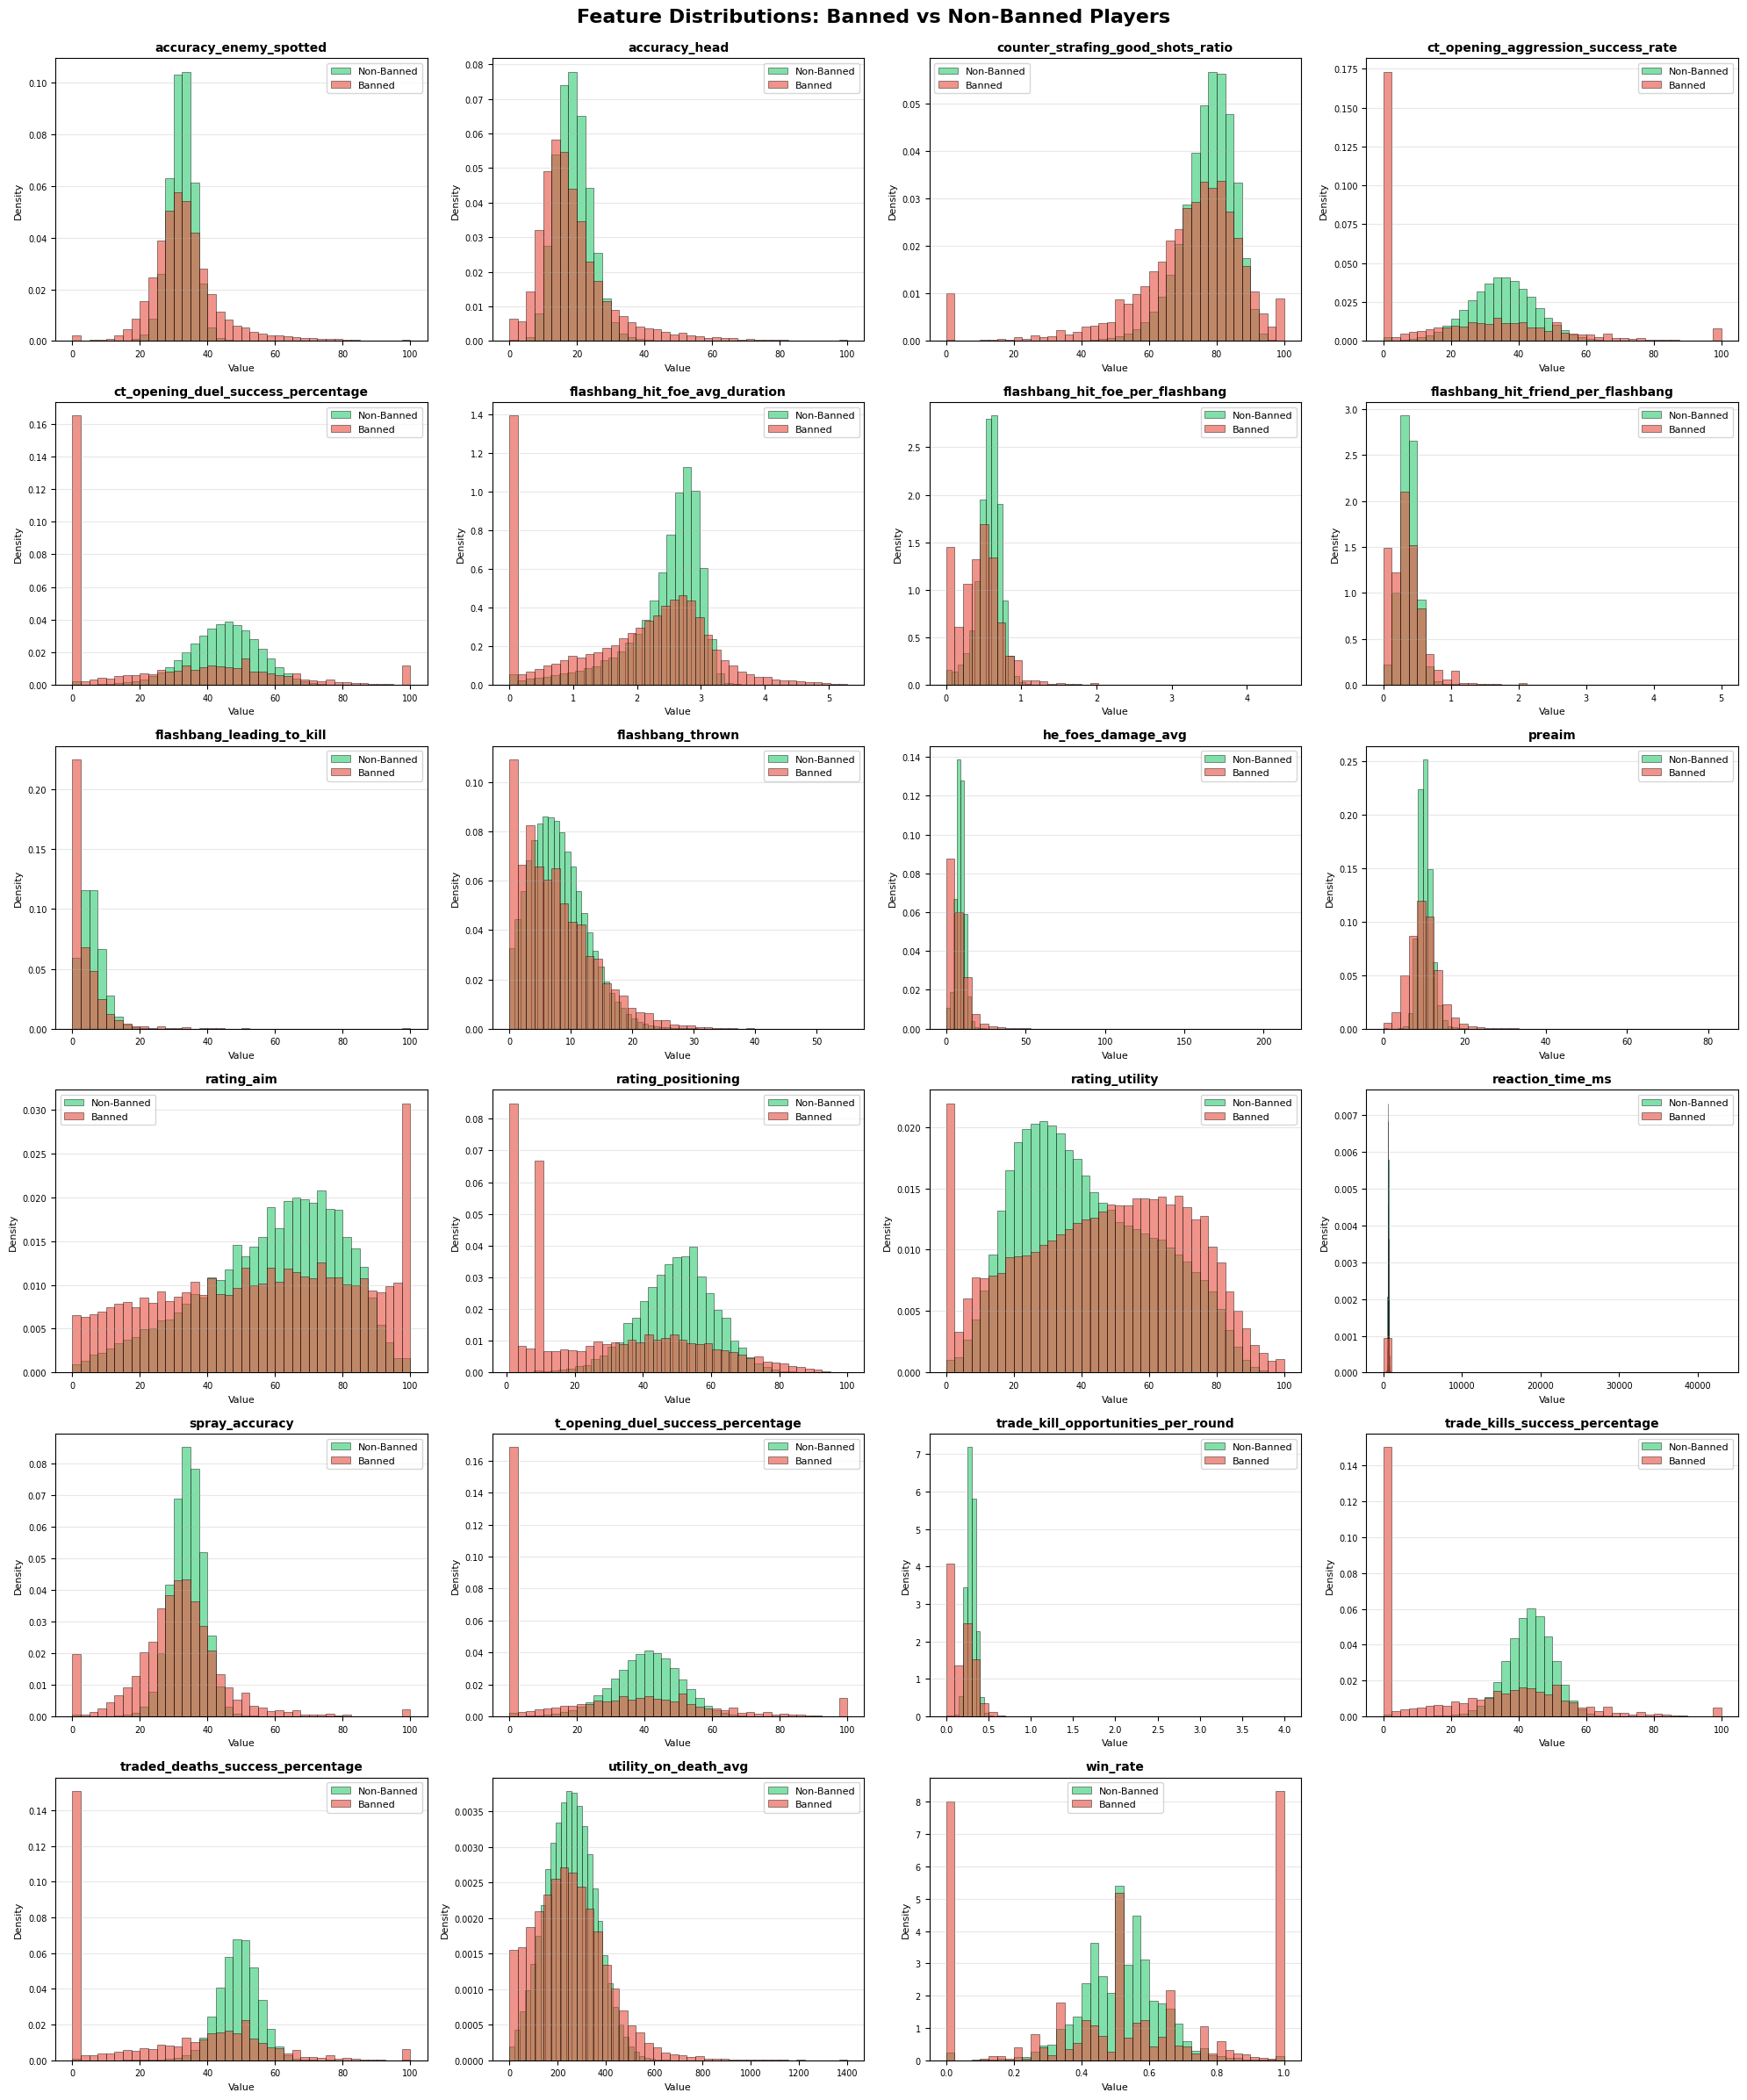

In [11]:
features = comparison_df['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = non_banned_player_data[feature].dropna()
    banned_data = banned_player_data[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6, color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)
    ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions: Banned vs Non-Banned Players', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Now im going to impute missing values for both banned and non banned players missing values (separately then recombine). Hopefully then the mean distributions will make more sense and not be severely skewed by missing data.

In [12]:
from sklearn.impute import KNNImputer

banned_data = banned_player_data.copy()
non_banned_data = non_banned_player_data.copy()

for col in numeric_cols:
    banned_data.loc[banned_data[col] == 0, col] = np.nan
    non_banned_data.loc[non_banned_data[col] == 0, col] = np.nan

print("\nMissing value percentages in banned players:")
banned_missing = (banned_data[numeric_cols].isna().sum() / len(banned_data) * 100).sort_values(ascending=False)
print(banned_missing.head(10))

print("\nMissing value percentages in non-banned players:")
non_banned_missing = (non_banned_data[numeric_cols].isna().sum() / len(non_banned_data) * 100).sort_values(ascending=False)
print(non_banned_missing.head(10))


Missing value percentages in banned players:
flashbang_leading_to_kill             47.036424
ct_opening_aggression_success_rate    42.970149
t_opening_duel_success_percentage     41.938847
ct_opening_duel_success_percentage    41.075274
traded_deaths_success_percentage      37.401120
trade_kills_success_percentage        37.233392
trade_kill_opportunities_per_round    34.162152
he_foes_damage_avg                    22.353181
win_rate                              20.004987
flashbang_hit_foe_avg_duration        18.044380
dtype: float64

Missing value percentages in non-banned players:
flashbang_leading_to_kill             4.150500
he_foes_damage_avg                    0.822860
flashbang_hit_friend_per_flashbang    0.703121
flashbang_hit_foe_per_flashbang       0.688733
ct_opening_aggression_success_rate    0.623294
win_rate                              0.566209
t_opening_duel_success_percentage     0.563889
flashbang_hit_foe_avg_duration        0.509124
ct_opening_duel_success_percentag

In [13]:
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

banned_imputed_values = knn_imputer.fit_transform(banned_data[numeric_cols])
banned_imputed = banned_data.copy()
banned_imputed[numeric_cols] = banned_imputed_values

non_banned_imputed_values = knn_imputer.fit_transform(non_banned_data[numeric_cols])
non_banned_imputed = non_banned_data.copy()
non_banned_imputed[numeric_cols] = non_banned_imputed_values

imputed_player_data = pd.concat([banned_imputed, non_banned_imputed], ignore_index=True)


Imputing banned players...
Imputing non-banned players...


In [7]:
banned_means_before = banned_player_data[numeric_cols].mean()
non_banned_means_before = non_banned_player_data[numeric_cols].mean()

banned_means_after = banned_imputed[numeric_cols].mean()
non_banned_means_after = non_banned_imputed[numeric_cols].mean()

pct_diff_before = ((banned_means_before - non_banned_means_before) / non_banned_means_before * 100).fillna(0)
pct_diff_after = ((banned_means_after - non_banned_means_after) / non_banned_means_after * 100).fillna(0)

comparison = pd.DataFrame({
    'Feature': numeric_cols,
    'Before - Banned': banned_means_before.values,
    'Before - Non-Banned': non_banned_means_before.values,
    'Before - Diff %': pct_diff_before.values,
    'After - Banned': banned_means_after.values,
    'After - Non-Banned': non_banned_means_after.values,
    'After - Diff %': pct_diff_after.values
})

comparison['Abs Diff After'] = comparison['After - Diff %'].abs()
comparison = comparison.sort_values('Abs Diff After', ascending=False)

Mean Comparison: Before vs After Imputation
                           Feature  Before - Banned  Before - Non-Banned  Before - Diff %  After - Banned  After - Non-Banned  After - Diff %  Abs Diff After
                rating_positioning        28.190894            49.777174       -43.365820       28.190894           49.777174      -43.365820       43.365820
                          win_rate         0.518938             0.516492         0.473420        0.661541            0.519810       27.265950       27.265950
         flashbang_leading_to_kill         3.639774             5.831504       -37.584303        7.413071            6.035140       22.831798       22.831798
trade_kill_opportunities_per_round         0.167282             0.293971       -43.095749        0.231766            0.294181      -21.216525       21.216525
    trade_kills_success_percentage        25.367823            43.252481       -41.349439       34.145220           43.333835      -21.204251       21.204251
  traded

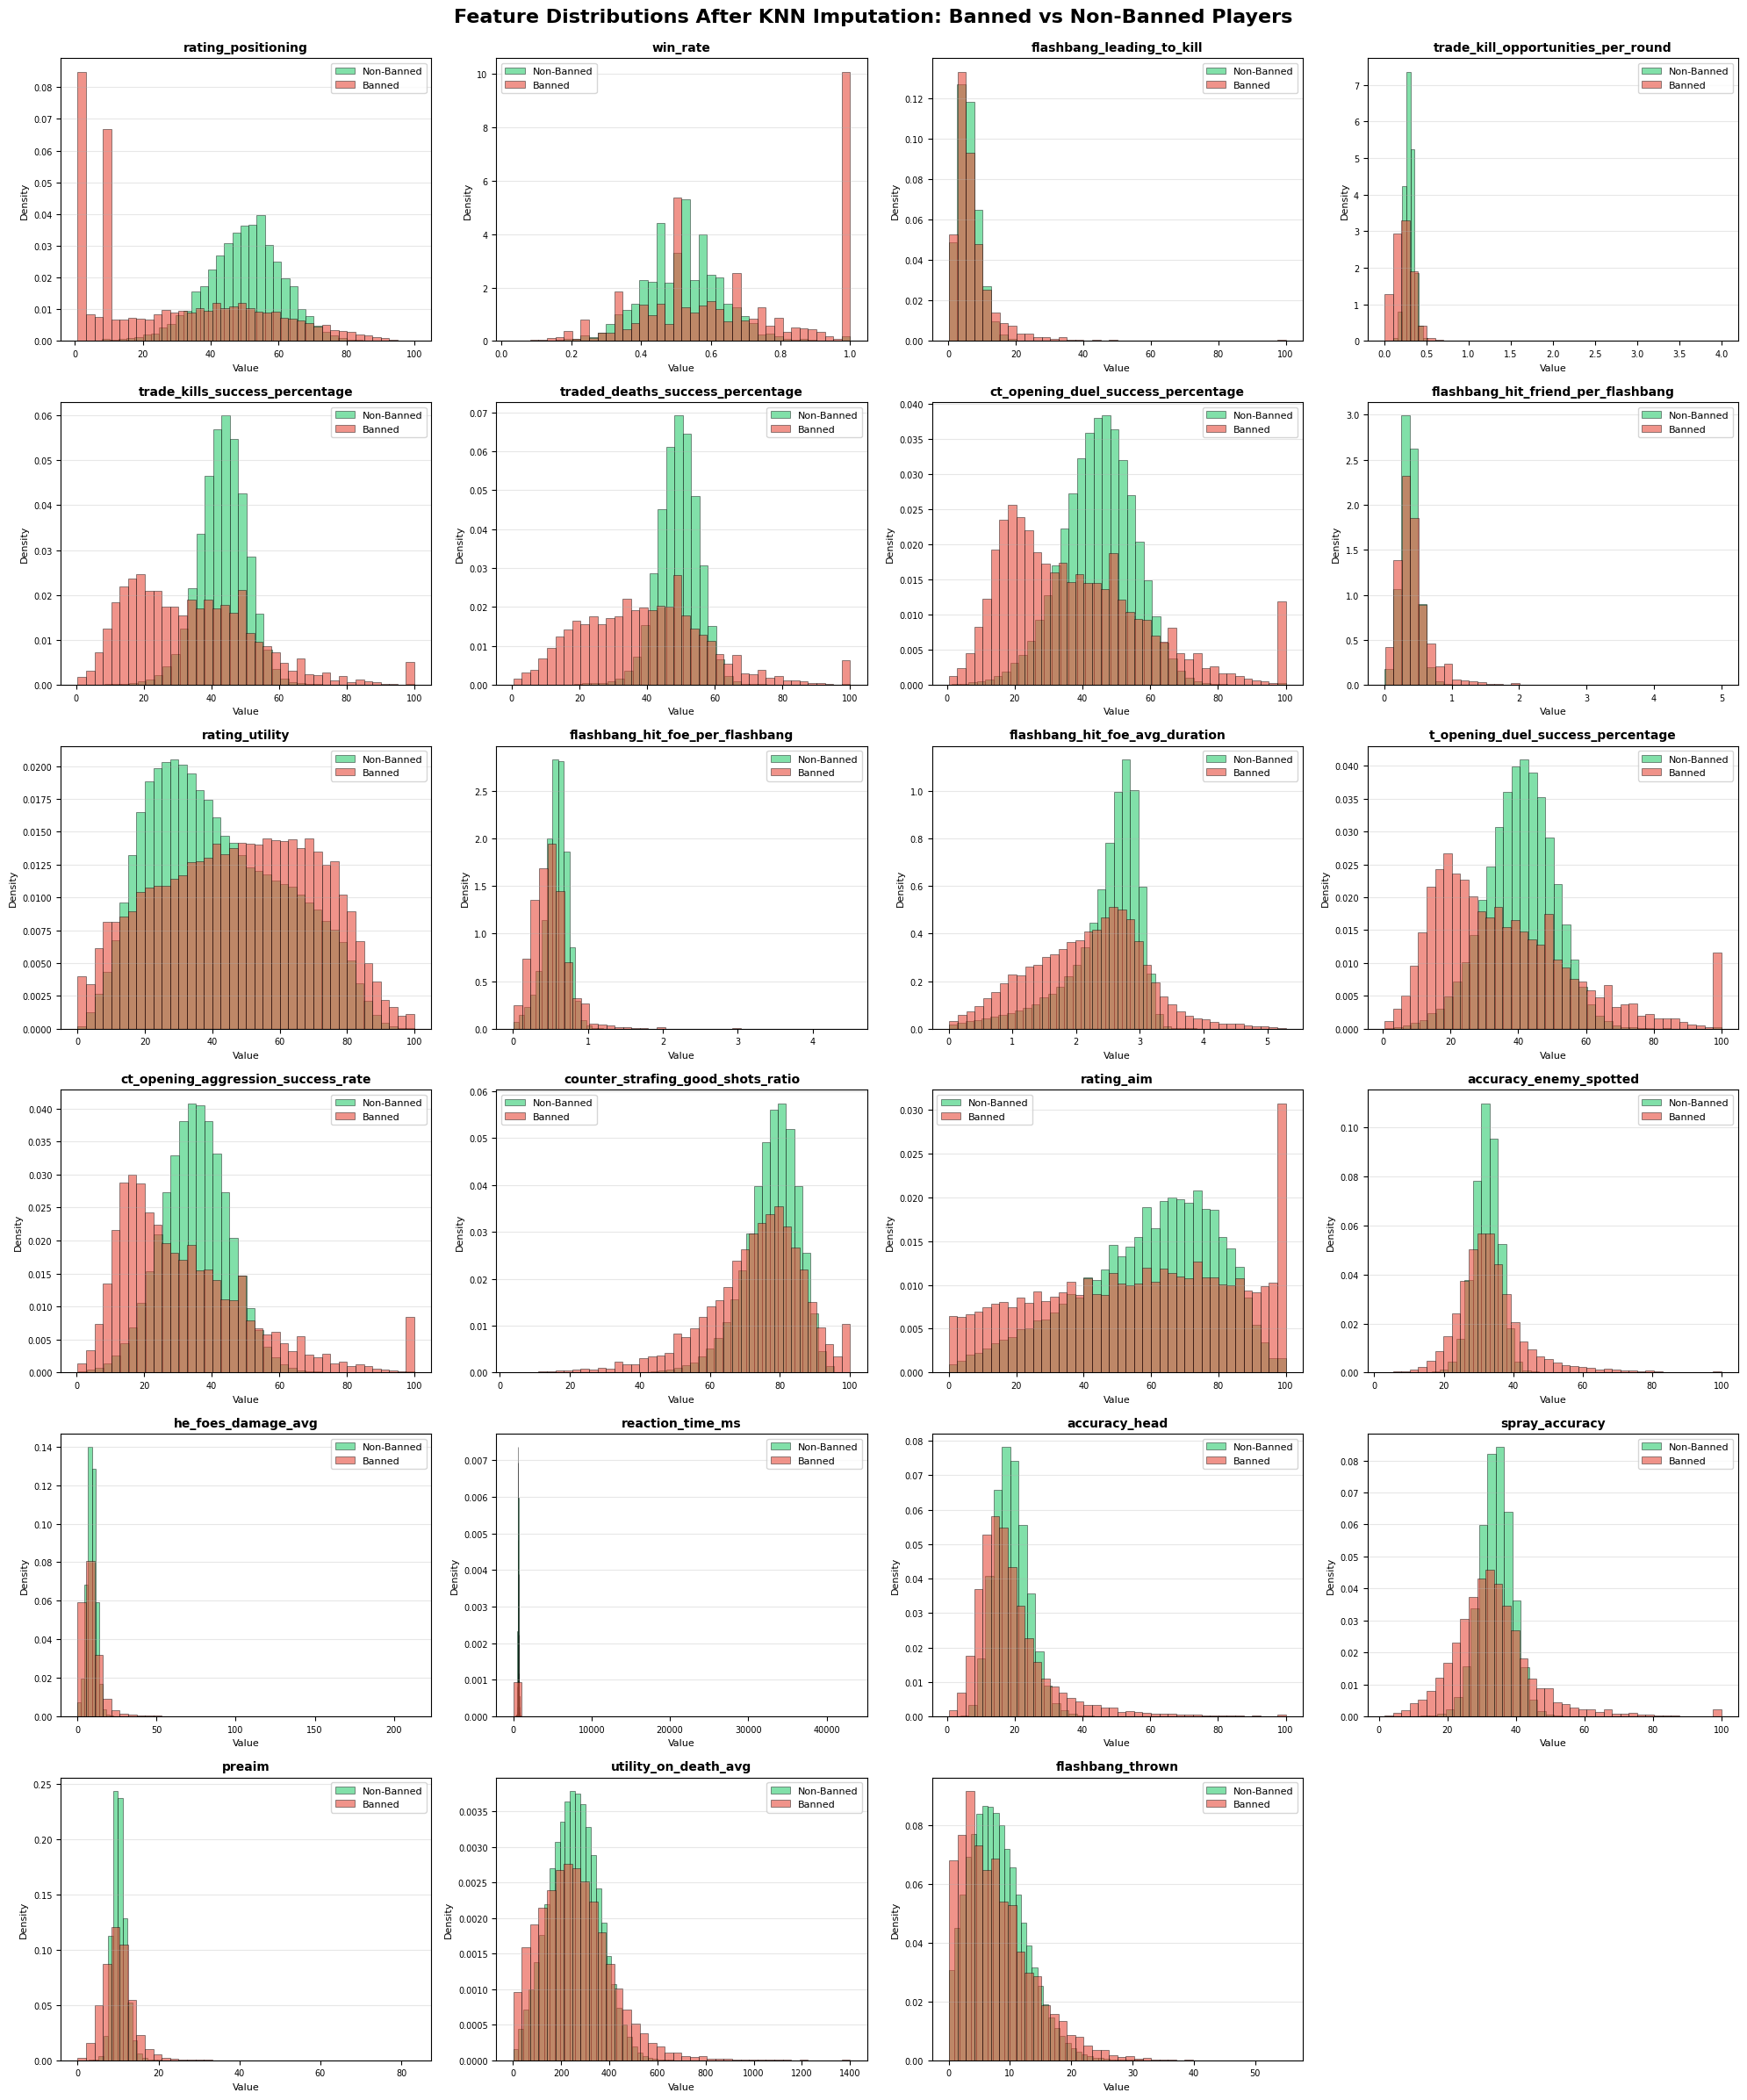

In [14]:
features = comparison['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = non_banned_imputed[feature].dropna()
    banned_data = banned_imputed[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6, color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)
    ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions After KNN Imputation: Banned vs Non-Banned Players', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Now I will do a side by side distribution for each feature to show the difference before and after imputation.

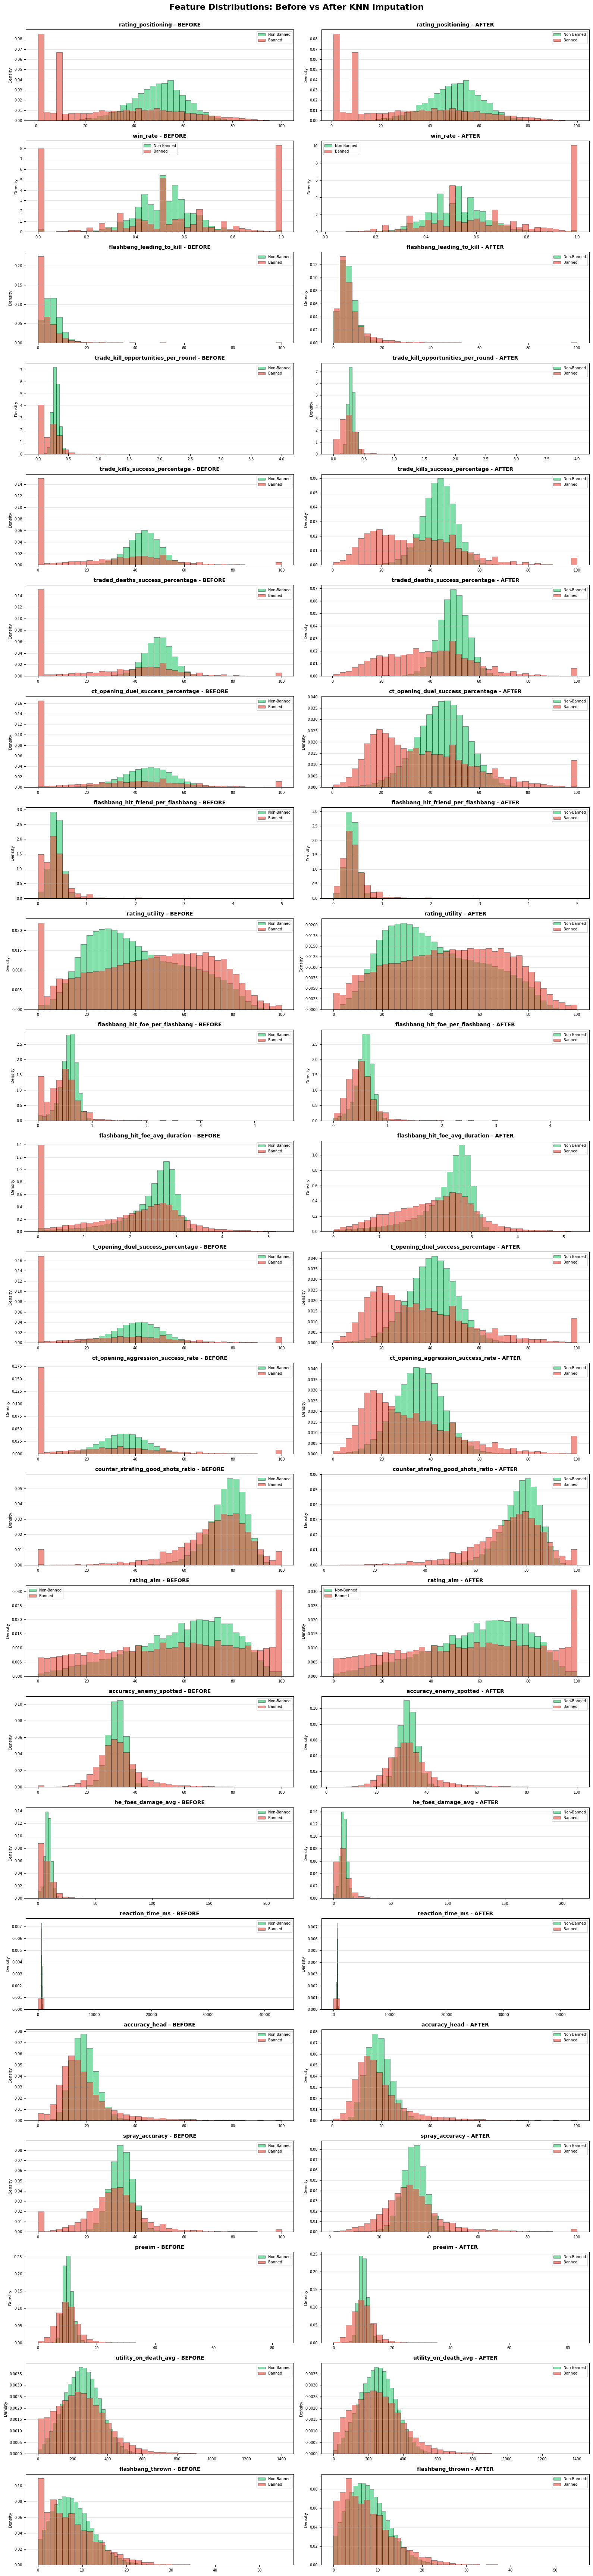

In [16]:
features = comparison['Feature'].tolist()

n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(16, n_features * 3))

for idx, feature in enumerate(features):
    # Before imputation
    ax_before = axes[idx, 0]
    ax_before.hist(non_banned_player_data[feature].dropna(), 
                   bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
                   label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax_before.hist(banned_player_data[feature].dropna(), 
                   bins=40, alpha=0.6, color=COLOUR_BANNED,
                   label='Banned', density=True, edgecolor='black', linewidth=0.5)
    ax_before.set_title(f'{feature} - BEFORE', fontsize=10, weight='bold')
    ax_before.set_ylabel('Density', fontsize=8)
    ax_before.grid(axis='y', alpha=0.3)
    ax_before.legend(fontsize=7)
    ax_before.tick_params(axis='both', labelsize=7)
    
    # After imputation
    ax_after = axes[idx, 1]
    ax_after.hist(non_banned_imputed[feature].dropna(), 
                  bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
                  label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax_after.hist(banned_imputed[feature].dropna(), 
                  bins=40, alpha=0.6, color=COLOUR_BANNED,
                  label='Banned', density=True, edgecolor='black', linewidth=0.5)
    ax_after.set_title(f'{feature} - AFTER', fontsize=10, weight='bold')
    ax_after.set_ylabel('Density', fontsize=8)
    ax_after.grid(axis='y', alpha=0.3)
    ax_after.legend(fontsize=7)
    ax_after.tick_params(axis='both', labelsize=7)

plt.suptitle('Feature Distributions: Before vs After Imputation', fontsize=16, weight='bold', y=1.0)
plt.tight_layout()
plt.show()